<a href="https://colab.research.google.com/github/shampabhusal/delay_forecast_tech_lab/blob/main/classifier_many_models_jan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# RUN THIS COMMAND ONLY IF YOU USE GOOGLE COLAB.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# RUN THIS COMMAND ONLY IF YOU USE GOOGLE COLAB.
%cd drive/MyDrive/TechLabs/project/flight_delay_kaggle

/content/drive/MyDrive/TechLabs/project/flight_delay_kaggle


#Flight Delay Prediction

Classification - Is the flight delayed acceptable or unacceptable?

Environment setup: import libraries and load the dataset
Data Analysis: understand the meaning and the predictive power of the variables
Feature Selection: evaluate and keep only the most relevant variables
Preprocessing: encode categorical variables and partition the dataset for training, tuning and testing
Model design: train, tune and test various models
Performance evaluation: evaluate the models based on their metrics
Explainability: understand how the model produces results

**Environment Setup**

In [ ]:
!pip install us 

In [3]:
#import us 
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE



In [4]:
#Loading the cleaned data
df = pd.read_csv('/content/drive/MyDrive/TechLabs/project/flight_delay_kaggle/cleaned1_flights.csv')

In [6]:
# Understanding the column data
print(df.info())
print(f"\nShape: {df.shape}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5231130 entries, 0 to 5231129
Data columns (total 19 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   MONTH                     int64 
 1   DAY_OF_WEEK               int64 
 2   AIRLINE                   object
 3   ORIGIN_AIRPORT            object
 4   DESTINATION_AIRPORT       object
 5   SCHEDULED_DEPARTURE       object
 6   DEPARTURE_TIME            object
 7   DEPARTURE_DELAY           int64 
 8   SCHEDULED_ARRIVAL         object
 9   ARRIVAL_TIME              object
 10  ARRIVAL_DELAY             int64 
 11  DISTANCE                  int64 
 12  AIR_TIME                  int64 
 13  ELAPSED_TIME              int64 
 14  SCHEDULED_DATE            object
 15  DEPARTURE_TIME_HOUR       int64 
 16  ARRIVAL_TIME_HOUR         int64 
 17  SCHEDULED_DEPARTURE_HOUR  int64 
 18  SCHEDULED_ARRIVAL_HOUR    int64 
dtypes: int64(11), object(8)
memory usage: 758.3+ MB
None

Shape: (5231130, 19)


In this analysis, I am selecting only one month, January because of the computaional issues. 

In [ ]:
months_to_check = [1, 2, 3]

for month in months_to_check:
    filtered_df = df[df['MONTH'] == month]
    print(f"Month {month}: total rows={len(filtered_df)}")


Month 1: total rows=457013
Month 2: total rows=407663
Month 3: total rows=492138


In [7]:
# filter dataframe to only include rows where month is January
january_data = df.loc[df['MONTH'] == 1]

In [ ]:
january_data.shape

(457013, 19)

In [ ]:
january_data.columns

Index(['MONTH', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT',
       'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME',
       'DEPARTURE_DELAY', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
       'DISTANCE', 'AIR_TIME', 'ELAPSED_TIME', 'SCHEDULED_DATE',
       'DEPARTURE_TIME_HOUR', 'ARRIVAL_TIME_HOUR', 'SCHEDULED_DEPARTURE_HOUR',
       'SCHEDULED_ARRIVAL_HOUR'],
      dtype='object')

In [ ]:
df['DEPARTURE_DELAY']

0         -11
1          -8
2          -2
3          -5
4          -1
           ..
5231125    -4
5231126    -4
5231127    -9
5231128    -6
5231129    15
Name: DEPARTURE_DELAY, Length: 5231130, dtype: int64

In our data the arrival delay and departure delay consist negative and zero values corresponding early arrival and on time. However, for this project our goal is predicting acceptable delay and unacceptable delay therefore we are dropping negative and zeros from our delay rows. 

In [8]:
# Create a new dataframe without negative and zero values in 'DEPARTURE_DELAY' and 'ARRIVAL_DELAY' columns
january_data = january_data[(january_data['DEPARTURE_DELAY'] > 0) & (january_data['ARRIVAL_DELAY'] > 0)]

In [10]:
january_data['DEPARTURE_DELAY'].unique()

array([  25,   12,   21,   72,   95,   13,    4,  108,    2,   60,   58,
          5,   53,   19,    7,    6,   43,   56,  148,   16,   55,   36,
         73,   39,   10,   15,  213,  119,  111,   22,    1,   68,   11,
        124,   27,   86,  102,    3,   54,   31,  131,    8,    9,   93,
         57,  106,   38,   29,  136,   76,  364,  164,   44,   28,   80,
         17,   67,   33,   32,   26,   61,   70,   34,   71,   47,   24,
        328,   45,   83,  133,  117,   62,  107,   51,   42,   75,   74,
         40,   82,   14,  205,   65,  100,  130,  171,   41,   96,  199,
         48,   63,   18,   46,  236,   78,  128,   35,   20,  180,   30,
         89,   59,   23,   85,   77,  113,   79,  264,  339,  165,  126,
         49,  127,  143,  146,  193,   52,  157,  176,  112,   37,  105,
         81,   50,  190,   69,  137,  188,  152,  167,  169,  492,   87,
         90,  139,  138,  297,  336,  115,  114,  332,   88,  151,   64,
        134,  163,  175,  243,  142,   66,  296,  1

In [11]:
january_data.shape

(130341, 19)

In [12]:
january_data.columns

Index(['MONTH', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT',
       'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME',
       'DEPARTURE_DELAY', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
       'DISTANCE', 'AIR_TIME', 'ELAPSED_TIME', 'SCHEDULED_DATE',
       'DEPARTURE_TIME_HOUR', 'ARRIVAL_TIME_HOUR', 'SCHEDULED_DEPARTURE_HOUR',
       'SCHEDULED_ARRIVAL_HOUR'],
      dtype='object')

In [13]:
january_cleaned = january_data[['DAY_OF_WEEK', 'AIRLINE', 'SCHEDULED_DEPARTURE_HOUR',
       'SCHEDULED_ARRIVAL_HOUR', 'ARRIVAL_DELAY', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'DISTANCE', 'AIR_TIME', 'ELAPSED_TIME']]

In [ ]:
(january_cleaned['ARRIVAL_DELAY']).value_counts()

1       3622
2       3612
4       3544
5       3535
3       3518
        ... 
649        1
681        1
751        1
679        1
1235       1
Name: ARRIVAL_DELAY, Length: 604, dtype: int64

## Preprocessing for Classification

In [21]:
# Count the number of values below 25
count_below_25 = len(january_cleaned[january_cleaned['ARRIVAL_DELAY'] <= 25])
# Count the number of values greater than 25
count_above_25 = len(january_cleaned[january_cleaned['ARRIVAL_DELAY'] > 25])
print(count_below_25, count_above_25)

68562 61779


In [60]:
# Count the number of instances in each class
count_below_25 = len(january_cleaned[january_cleaned['ARRIVAL_DELAY'] <= 25])
count_above_25 = len(january_cleaned[january_cleaned['ARRIVAL_DELAY'] > 25])

# Calculate the proportion of instances in each class
acceptable_proportions = count_below_25 / len(january_cleaned)
unacceptable_proportions = count_above_25 / len(january_cleaned)

# Check if the classification is balanced
if abs(acceptable_proportions - unacceptable_proportions) < 0.1:
    print('The classification is balanced.')
else:
    print('The classification is imbalanced.')
    
print('Acceptable proportion:', acceptable_proportions)
print('Unacceptable proportion:', unacceptable_proportions)


The classification is balanced.
Acceptable proportion: 0.526020208529933
Unacceptable proportion: 0.47397979147006697


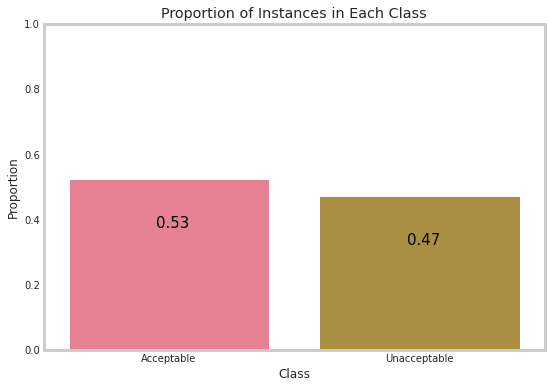

<Figure size 432x288 with 0 Axes>

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the number of instances in each class
count_below_25 = len(january_cleaned[january_cleaned['ARRIVAL_DELAY'] <= 25])
count_above_25 = len(january_cleaned[january_cleaned['ARRIVAL_DELAY'] > 25])

# Calculate the proportion of instances in each class
acceptable_proportions = count_below_25 / len(january_cleaned)
unacceptable_proportions = count_above_25 / len(january_cleaned)

# Create a bar chart
labels = ['Acceptable', 'Unacceptable']
proportions = [acceptable_proportions, unacceptable_proportions]
sns.set_style('whitegrid')
sns.set_palette('husl')
plt.figure(figsize=(8,6))
ax = sns.barplot(x=labels, y=proportions)
plt.title('Proportion of Instances in Each Class')
plt.xlabel('Class')
plt.ylabel('Proportion')
ax.set_ylim([0,1])
for i in ax.patches:
    ax.text(i.get_x()+0.35, i.get_height()-0.15, str(round(i.get_height(), 2)), fontsize=15, color='black')
plt.grid(False)
plt.show()
plt.savefig("/content/drive/MyDrive/TechLabs/project/flight_delay_kaggle/final_report/proportion_instances")

In [ ]:
january_cleaned.shape

(130338, 8)

In [28]:
january_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130341 entries, 20 to 457010
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   DAY_OF_WEEK               130341 non-null  int64 
 1   AIRLINE                   130341 non-null  object
 2   SCHEDULED_DEPARTURE_HOUR  130341 non-null  int64 
 3   SCHEDULED_ARRIVAL_HOUR    130341 non-null  int64 
 4   ARRIVAL_DELAY             130341 non-null  int64 
 5   ORIGIN_AIRPORT            130341 non-null  object
 6   DESTINATION_AIRPORT       130341 non-null  object
 7   DISTANCE                  130341 non-null  int64 
 8   AIR_TIME                  130341 non-null  int64 
 9   ELAPSED_TIME              130341 non-null  int64 
dtypes: int64(7), object(3)
memory usage: 10.9+ MB


Encoding the categorical variables

In [29]:
encoded_january = pd.get_dummies(january_cleaned, columns=['DAY_OF_WEEK', 'AIRLINE', 'SCHEDULED_DEPARTURE_HOUR', 
                                                           'SCHEDULED_ARRIVAL_HOUR', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT'])

In [30]:
encoded_january.shape

(130341, 696)

Splitting the dataset into train, tuning and test data in proportion of 60% - 20% -20% respectively. 

In [31]:


# Split the data into training and temporary sets
train_data_jan, temp_data = train_test_split(encoded_january, test_size=0.4, random_state=42)

# Split the temporary set into tuning and test sets
tuning_data_jan, test_data_jan = train_test_split(temp_data, test_size=0.5, random_state=42)

# Check the size of each dataset
print("Training data size:", len(train_data_jan))
print("Tuning data size:", len(tuning_data_jan))
print("Test data size:", len(test_data_jan))



Training data size: 78204
Tuning data size: 26068
Test data size: 26069


The code below first defines a function get_delay_class that maps arrival delay to either 'acceptable_delay' or 'unacceptable_delay'. This function is applied to the 'ARRIVAL_DELAY' column of the training, tuning, and test data to create a new column 'DELAY_CLASS'. Then, the features (all columns except 'ARRIVAL_DELAY' and 'DELAY_CLASS') and target variables ('DELAY_CLASS') are separated for the training, tuning, and test data.


In [64]:
# Define the delay classes
def get_delay_class(arrival_delay):
    if arrival_delay <= 25:
        return 'acceptable_delay'
    else:
        return 'unacceptable_delay'

# Apply the function to create the DELAY_CLASS column
train_data_jan['DELAY_CLASS'] = train_data_jan['ARRIVAL_DELAY'].apply(get_delay_class)
tuning_data_jan['DELAY_CLASS'] = tuning_data_jan['ARRIVAL_DELAY'].apply(get_delay_class)
test_data_jan['DELAY_CLASS'] = test_data_jan['ARRIVAL_DELAY'].apply(get_delay_class)

# Separate the features and target variables
X_train = train_data_jan.drop(['ARRIVAL_DELAY', 'DELAY_CLASS'], axis=1)
y_train = train_data_jan['DELAY_CLASS']
X_tuning = tuning_data_jan.drop(['ARRIVAL_DELAY', 'DELAY_CLASS'], axis=1)
y_tuning = tuning_data_jan['DELAY_CLASS']
X_test = test_data_jan.drop(['ARRIVAL_DELAY', 'DELAY_CLASS'], axis=1)
y_test = test_data_jan['DELAY_CLASS']

In [65]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier

# Encode the target variable as integers
le = LabelEncoder()
y_train_le = le.fit_transform(train_data_jan['DELAY_CLASS'])
y_tuning_le = le.transform(tuning_data_jan['DELAY_CLASS'])
y_test_le = le.transform(test_data_jan['DELAY_CLASS'])
# Apply SMOTE to resample the imbalanced data
#smote = SMOTE(random_state=42)
#X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_le)

## Modeling Different Classifiers

**Logistic Regression**

This code performs binary classification of flight arrival delays into two classes: acceptable_delay and unacceptable_delay, using logistic regression.

A logistic regression model is fitted on the trained data using fit method.

The trained model is used to predict the delay class on the tuning and test data, and the performance of the model is evaluated using various metrics: accuracy, precision, recall, and F1-score. These metrics are calculated using accuracy_score, precision_score, recall_score, and f1_score functions from the sklearn.metrics module.

Finally, a confusion matrix is created for the tuning data using confusion_matrix function from the sklearn.metrics module, and a heatmap is plotted using sns.heatmap. Also, a classification report is created using classification_report function from the sklearn.metrics module. The classification report provides precision, recall, and F1-score for each class as well as the average values.

Tuning data performance:
Accuracy: 0.6176538284486727
Precision: 0.6188560455827593
Recall: 0.6176538284486727
F1-score: 0.611695440840709
-------------------
Test data performance:
Accuracy: 0.6149449537765161
Precision: 0.6151374686512602
Recall: 0.6149449537765161
F1-score: 0.6092789964514979


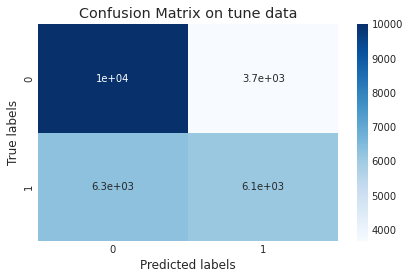

                    precision    recall  f1-score   support

  acceptable_delay       0.61      0.73      0.67     13661
unacceptable_delay       0.63      0.49      0.55     12407

          accuracy                           0.62     26068
         macro avg       0.62      0.61      0.61     26068
      weighted avg       0.62      0.62      0.61     26068

[[10003  3658]
 [ 6309  6098]]


In [94]:
from sklearn.metrics import confusion_matrix, classification_report

# Fit logistic regression model on the resampled data
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Use the trained model to predict the delay class on the tuning and test data
y_tuning_pred = lr.predict(X_tuning)
y_test_pred = lr.predict(X_test)

# Evaluate the performance of the model on the tuning and test data
print('Tuning data performance:')
print('Accuracy:', accuracy_score(y_tuning, y_tuning_pred))
print('Precision:', precision_score(y_tuning, y_tuning_pred, average='weighted'))
print('Recall:', recall_score(y_tuning, y_tuning_pred, average='weighted'))
print('F1-score:', f1_score(y_tuning, y_tuning_pred, average='weighted'))
print('-------------------')
print('Test data performance:')
print('Accuracy:', accuracy_score(y_test, y_test_pred))
print('Precision:', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall:', recall_score(y_test, y_test_pred, average='weighted'))
print('F1-score:', f1_score(y_test, y_test_pred, average='weighted'))

# Create a confusion matrix for the tune data
cm_tuning_lr = confusion_matrix(y_tuning, y_tuning_pred)
sns.heatmap(cm_tuning_lr, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix on tune data')
plt.show()
#plt.savefig("/content/drive/MyDrive/TechLabs/project/flight_delay_kaggle/final_report/lr_confusion_matrix")

# Create a classification report for the tune data
report = classification_report(y_tuning, y_tuning_pred)
print(report)
print(cm_tuning_lr)

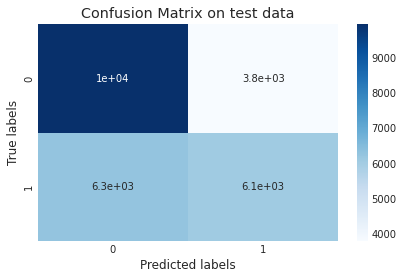

In [96]:

# Create a confusion matrix for the test data
cm_test_lr = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test_lr, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix on test data')
plt.savefig("/content/drive/MyDrive/TechLabs/project/flight_delay_kaggle/final_report/lr_confusion_matrix")
plt.show()


A confusion matrix is a table that shows the number of true positives, false positives, true negatives, and false negatives for each class. 

Based on the given numbers, the model's performance on both tuning and test data is similar, with slightly higher performance on the tuning data. The accuracy of the model on the tuning data is 0.6176 and on the test data is 0.6149. This suggests that the model is not overfitting the data and is performing reasonably well on unseen data.

The precision and recall values for the two classes (acceptable_delay and unacceptable_delay) are similar, with slightly higher values for acceptable_delay. The precision of the model on the tuning data is 0.6189 and on the test data is 0.6151. The recall of the model on the tuning data and test data is the same at 0.6177.

The F1-score of the model on the tuning data is 0.6117 and on the test data is 0.6093, which suggests that the model is performing relatively well on both tuning and test data.

Looking at the confusion matrix, we can see that the model is better at predicting acceptable_delay with 10003 correct predictions out of 13661 instances. However, the model is not performing as well at predicting unacceptable_delay, with only 6098 correct predictions out of 12407 instances.

Overall, the model's performance is decent but could potentially be improved, especially for the unacceptable_delay class.

**Decision Tree Classifier**

In [67]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Create the decision tree model
dt = DecisionTreeClassifier(random_state=42)

# Train the model
dt.fit(X_train, y_train)

# Predict on the tuning data
y_tuning_pred_dt = dt.predict(X_tuning)
# Predict on the testing data
y_test_pred_dt = dt.predict(X_test)

# Evaluate the performance of the model on the tuning 
print('Tuning data performance of decision tree model:')
print('Accuracy:', accuracy_score(y_tuning, y_tuning_pred_dt))
print('Precision:', precision_score(y_tuning, y_tuning_pred_dt, average='weighted'))
print('Recall:', recall_score(y_tuning, y_tuning_pred_dt, average='weighted'))
print('F1-score:', f1_score(y_tuning, y_tuning_pred_dt, average='weighted'))




# Evaluate the performance of the model on the testing 
print('----------------------------------\n')
print('Test data performance of decision tree model:')
print('Accuracy:', accuracy_score(y_test, y_test_pred_dt))
print('Precision:', precision_score(y_test, y_test_pred_dt, average='weighted'))
print('Recall:', recall_score(y_test, y_test_pred_dt, average='weighted'))
print('F1-score:', f1_score(y_test, y_test_pred_dt, average='weighted'))

Tuning data performance of decision tree model:
Accuracy: 0.5602270983581402
Precision: 0.5600803287837357
Recall: 0.5602270983581402
F1-score: 0.5601467447575882
----------------------------------

Test data performance of decision tree model:
Accuracy: 0.5644635390693927
Precision: 0.5645898045056146
Recall: 0.5644635390693927
F1-score: 0.5645228374606422


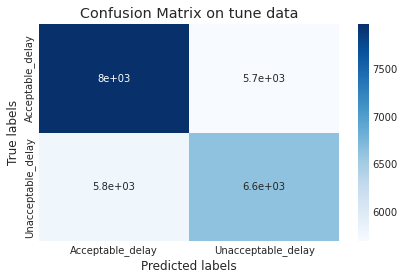

Decision tree report on tune data: 
                     precision    recall  f1-score   support

  acceptable_delay       0.58      0.58      0.58     13661
unacceptable_delay       0.54      0.53      0.54     12407

          accuracy                           0.56     26068
         macro avg       0.56      0.56      0.56     26068
      weighted avg       0.56      0.56      0.56     26068

confusion_matrix: 
 [[7975 5686]
 [5778 6629]]


In [71]:
from sklearn.metrics import confusion_matrix, classification_report
# Define the class names
class_names = ['Acceptable_delay', 'Unacceptable_delay']

# Create a confusion matrix for the tune data
cm_tuning_dt = confusion_matrix(y_tuning, y_tuning_pred_dt)
sns.heatmap(cm_tuning_dt, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix on tune data')
#plt.savefig("/content/drive/MyDrive/TechLabs/project/flight_delay_kaggle/final_report/dt_confusion_matrix")
plt.show()

# Create a classification report for the tune data
report = classification_report(y_tuning, y_tuning_pred_dt)
print('Decision tree report on tune data: \n',report)
print('confusion_matrix: \n',cm_tuning_dt)

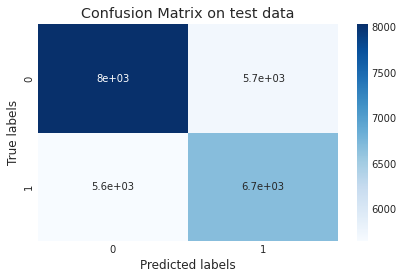

Decision tree report on test data: 
                     precision    recall  f1-score   support

  acceptable_delay       0.59      0.58      0.59     13747
unacceptable_delay       0.54      0.54      0.54     12322

          accuracy                           0.56     26069
         macro avg       0.56      0.56      0.56     26069
      weighted avg       0.56      0.56      0.56     26069

confusion_matrix: 
 [[8036 5711]
 [5643 6679]]


In [90]:
from sklearn.metrics import confusion_matrix, classification_report
# Create a confusion matrix for the test data
cm_test_dt = confusion_matrix(y_test, y_test_pred_dt)
sns.heatmap(cm_test_dt, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix on test data')
plt.savefig("/content/drive/MyDrive/TechLabs/project/flight_delay_kaggle/final_report/dt_confusion_matrix")
plt.show()

# Create a classification report for the test data
report = classification_report(y_test, y_test_pred_dt)
print('Decision tree report on test data: \n',report)
print('confusion_matrix: \n',cm_test_dt)

**Random Forest**

Tuning data performance:
Accuracy: 0.5867346938775511
Precision: 0.5855766306867032
Recall: 0.5867346938775511
F1-score: 0.584533482296282
-------------------

Test data performance:
Accuracy: 0.5891288503586636
Precision: 0.58773343037447
Recall: 0.5891288503586636
F1-score: 0.5869061225431291


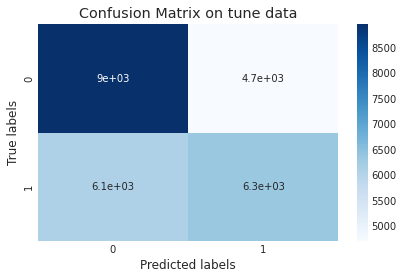

                    precision    recall  f1-score   support

  acceptable_delay       0.60      0.66      0.62     13661
unacceptable_delay       0.57      0.51      0.54     12407

          accuracy                           0.59     26068
         macro avg       0.59      0.58      0.58     26068
      weighted avg       0.59      0.59      0.58     26068

[[8958 4703]
 [6070 6337]]


In [74]:
from sklearn.ensemble import RandomForestClassifier
# Create a Random Forest classifier object
rf_clf = RandomForestClassifier(random_state=42)

# Fit the model on resampled data
rf_clf.fit(X_train, y_train)


# Use the trained model to predict the delay class on the tuning and test data
y_tuning_pred_clf = rf_clf.predict(X_tuning)
y_test_pred_clf = rf_clf.predict(X_test)

# Evaluate the performance of the model on the tuning and test data
print('Tuning data performance:')
print('Accuracy:', accuracy_score(y_tuning, y_tuning_pred_clf))
print('Precision:', precision_score(y_tuning, y_tuning_pred_clf, average='weighted'))
print('Recall:', recall_score(y_tuning, y_tuning_pred_clf, average='weighted'))
print('F1-score:', f1_score(y_tuning, y_tuning_pred_clf, average='weighted'))
print('-------------------\n')
print('Test data performance:')
print('Accuracy:', accuracy_score(y_test, y_test_pred_clf))
print('Precision:', precision_score(y_test, y_test_pred_clf, average='weighted'))
print('Recall:', recall_score(y_test, y_test_pred_clf, average='weighted'))
print('F1-score:', f1_score(y_test, y_test_pred_clf, average='weighted'))

# Create a confusion matrix for the tune data
cm_tuning_clf = confusion_matrix(y_tuning, y_tuning_pred_clf)
sns.heatmap(cm_tuning_clf, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix on tune data')
#plt.savefig("/content/drive/MyDrive/TechLabs/project/flight_delay_kaggle/final_report/rf_confusion_matrix")
plt.show()

# Create a classification report for the tune data
report = classification_report(y_tuning, y_tuning_pred_clf)
print(report)
print(cm_tuning_clf)

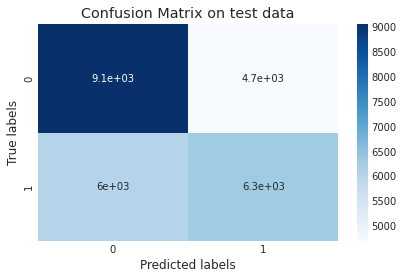

In [91]:
# Create a confusion matrix for the test data
cm_test_clf = confusion_matrix(y_test, y_test_pred_clf)
sns.heatmap(cm_test_clf, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix on test data')
plt.savefig("/content/drive/MyDrive/TechLabs/project/flight_delay_kaggle/final_report/rf_confusion_matrix")
plt.show()


**Extra Tree Classifier**

Tuning data performance:
Accuracy: 0.5677075341414761
Precision: 0.5665798529302977
Recall: 0.5677075341414761
F1-score: 0.5664677713320939
-------------------
Test data performance:
Accuracy: 0.571291572365645
Precision: 0.5700263825009049
Recall: 0.571291572365645
F1-score: 0.5700221848332728


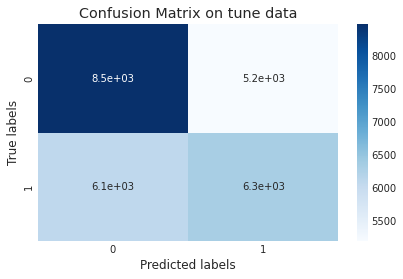

                    precision    recall  f1-score   support

  acceptable_delay       0.58      0.62      0.60     13661
unacceptable_delay       0.55      0.51      0.53     12407

          accuracy                           0.57     26068
         macro avg       0.57      0.57      0.56     26068
      weighted avg       0.57      0.57      0.57     26068

[[8476 5185]
 [6084 6323]]


In [75]:
from sklearn.ensemble import ExtraTreesClassifier
# Create an ExtraTreeClassifier object
etc_clf = ExtraTreesClassifier(random_state=42)

# Fit the model on resampled data
etc_clf.fit(X_train, y_train)

# Use the trained model to predict the delay class on the tuning and test data
y_tuning_pred_etc = etc_clf.predict(X_tuning)
y_test_pred_etc = etc_clf.predict(X_test)

# Evaluate the performance of the model on the tuning and test data
print('Tuning data performance:')
print('Accuracy:', accuracy_score(y_tuning, y_tuning_pred_etc))
print('Precision:', precision_score(y_tuning, y_tuning_pred_etc, average='weighted'))
print('Recall:', recall_score(y_tuning, y_tuning_pred_etc, average='weighted'))
print('F1-score:', f1_score(y_tuning, y_tuning_pred_etc, average='weighted'))
print('-------------------')
print('Test data performance:')
print('Accuracy:', accuracy_score(y_test, y_test_pred_etc))
print('Precision:', precision_score(y_test, y_test_pred_etc, average='weighted'))
print('Recall:', recall_score(y_test, y_test_pred_etc, average='weighted'))
print('F1-score:', f1_score(y_test, y_test_pred_etc, average='weighted'))

# Create a confusion matrix for the tune data
cm_tuning_etc = confusion_matrix(y_tuning, y_tuning_pred_etc)
sns.heatmap(cm_tuning_etc, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix on tune data')
#plt.savefig("/content/drive/MyDrive/TechLabs/project/flight_delay_kaggle/final_report/etc_confusion_matrix")
plt.show()

# Create a classification report for the tune data
report = classification_report(y_tuning, y_tuning_pred_etc)
print(report)
print(cm_tuning_etc)

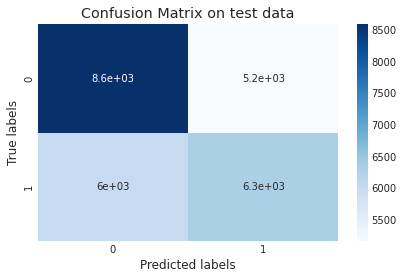

In [92]:
# Create a confusion matrix for the tune data
cm_test_etc = confusion_matrix(y_test, y_test_pred_etc)
sns.heatmap(cm_test_etc, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix on test data')
plt.savefig("/content/drive/MyDrive/TechLabs/project/flight_delay_kaggle/final_report/etc_confusion_matrix")
plt.show()

**Gradient Boosting Classifier (XGBoost)**

Tuning data performance:
Accuracy: 0.6249808193954274
Precision: 0.6281532465539957
Recall: 0.6249808193954274
F1-score: 0.6171438942536315
-------------------
Test data performance:
Accuracy: 0.6271049906018643
Precision: 0.6293500167243622
Recall: 0.6271049906018643
F1-score: 0.6195747539050134


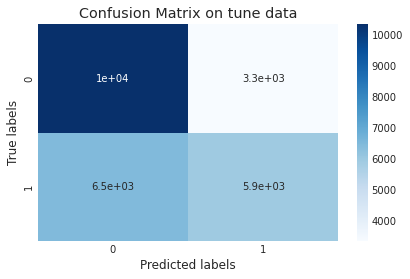

              precision    recall  f1-score   support

           0       0.62      0.76      0.68     13661
           1       0.64      0.48      0.55     12407

    accuracy                           0.62     26068
   macro avg       0.63      0.62      0.61     26068
weighted avg       0.63      0.62      0.62     26068

[[10343  3318]
 [ 6458  5949]]


In [81]:
import xgboost as xgb

# Create XGBoost classifier object
xgb_clf = xgb.XGBClassifier()

# Fit the model on training data
xgb_clf.fit(X_train, y_train_le)
# Use the trained classifier to predict the delay class on the tuning and test data
y_tuning_pred_xgb = xgb_clf.predict(X_tuning)
y_test_pred_xgb = xgb_clf.predict(X_test)

# Evaluate the performance of the classifier on the tuning and test data
print('Tuning data performance:')
print('Accuracy:', accuracy_score(y_tuning_le, y_tuning_pred_xgb))
print('Precision:', precision_score(y_tuning_le, y_tuning_pred_xgb, average='weighted'))
print('Recall:', recall_score(y_tuning_le, y_tuning_pred_xgb, average='weighted'))
print('F1-score:', f1_score(y_tuning_le, y_tuning_pred_xgb, average='weighted'))
print('-------------------')
print('Test data performance:')
print('Accuracy:', accuracy_score(y_test_le, y_test_pred_xgb))
print('Precision:', precision_score(y_test_le, y_test_pred_xgb, average='weighted'))
print('Recall:', recall_score(y_test_le, y_test_pred_xgb, average='weighted'))
print('F1-score:', f1_score(y_test_le, y_test_pred_xgb, average='weighted'))

# Create a confusion matrix for the tune data
cm_tuning_xgb = confusion_matrix(y_tuning_le, y_tuning_pred_xgb)
sns.heatmap(cm_tuning_xgb, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix on tune data')
plt.show()

# Create a classification report for the tune data
report = classification_report(y_tuning_le, y_tuning_pred_xgb)
print(report)
print(cm_tuning_xgb)

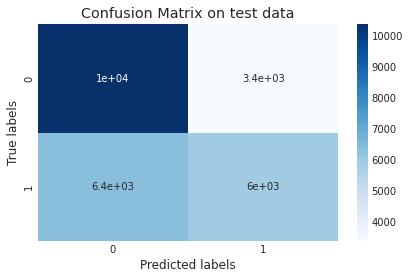

In [83]:
# Create a confusion matrix for the tune data
cm_test_xgb = confusion_matrix(y_test_le, y_test_pred_xgb)
sns.heatmap(cm_test_xgb, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix on test data')
plt.savefig("/content/drive/MyDrive/TechLabs/project/flight_delay_kaggle/final_report/xgb_confusion_matrix")
plt.show()

##Performance Evaluation

<style>
  table {
    border-collapse: collapse;
    width: 100%;
  }

  th, td {
    text-align: left;
    padding: 8px 16px;
    border: 1px solid black;
  }

  th {
    background-color: #f2f2f2;
  }

  td + td {
    padding-left: 32px;
  }
</style>

<table>
  <tr>
    <th>Classification Model</th>
    <th>Precision </th>
   <th> Recall	<th>
   <th> F1 <th>
   <th> Accuracy<th>
  </tr>
  <tr>
    <td>Logistic Regression</td>
    <td> 0.62</td>
    <td> 0.61<td></td>
    <td> 0.61<td></td>
    <td> 0.61</td>
  </tr>
  <tr>
    <td>Decision Tree Classifier</td>
      <td>0.56</td>
    <td> 0.56<td></td>
    <td> 0.56<td></td>
    <td> 0.56</td>
  </tr>
  </tr>
  <tr>
    <td>Random Forest</td>
    <td> 0.59</td>
    <td> 0.59<td></td>
    <td> 0.59<td></td>
    <td> 0.59</td>
  </tr>
  </tr>
  <tr>
    <td>Extra Tree Classifier</td>
    <td> 0.57</td>
    <td> 0.57<td></td>
    <td> 0.57<td></td>
    <td> 0.57</td>
  </tr>
  <tr>
    <td>Gradient Boosting Classifier</td>
    <td> 0.62</td>
    <td> 0.62<td></td>
    <td> 0.62<td></td>
    <td> 0.62</td>
  </tr>
</table>


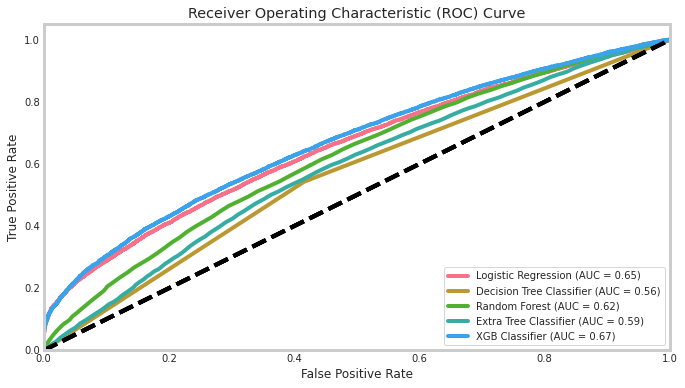

Logistic Regression AUC score: 0.67
Decision Tree Classifier AUC score: 0.67
Random Forest AUC score: 0.67
Extra Tree Classifier AUC score: 0.67
XGB Classifier AUC score: 0.67


In [84]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# Define the figure size
fig = plt.figure(figsize=(10, 6))

# Define a function to plot the ROC curve
def plot_roc_curve(fpr, tpr, auc_score, model_name):
    plt.plot(fpr, tpr, label='%s (AUC = %0.2f)' % (model_name, auc_score))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")


# Define the models to evaluate
models = {
    'Logistic Regression': lr,
    'Decision Tree Classifier': dt,
    'Random Forest': rf_clf,
    'Extra Tree Classifier': etc_clf,
    'XGB Classifier': xgb_clf
}

# Plot the ROC curve for each model
for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test_le, y_pred_proba)
    auc_score = auc(fpr, tpr)
    plot_roc_curve(fpr, tpr, auc_score, name)
    plt.grid(False)
plt.savefig("/content/drive/MyDrive/TechLabs/project/flight_delay_kaggle/final_report/roc_curve")
plt.show()

# Calculate AUC score for each model
for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test)[:,1]
    auc_score = auc(fpr, tpr)
    print('%s AUC score: %0.2f' % (name, auc_score))


The AUC (Area Under the Curve) score is a measure of the performance of a binary classification model. It represents the area under the ROC (Receiver Operating Characteristic) curve, which plots the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.

In general, an AUC score of 0.5 indicates a model that performs no better than random guessing, while an AUC score of 1.0 indicates a perfect model. Therefore, an AUC score of 0.67 suggests that the models evaluated here are performing better than random guessing